In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
    
import sys 
sys.path.insert(0, '../src/')

import warnings; warnings.simplefilter('ignore')
import emcee
import corner
from multiprocess import Pool
import time
import galhalo
import mcmc_aux

import jsm_prephalo, jsm_stats
from scipy.stats import ks_2samp, anderson_ksamp

In [3]:
samples = np.load("../../data/MCMC/sampler_results_sep17.npy")
print("steps:", samples.shape[0])
print("walkers:", samples.shape[1])
print("dim:", samples.shape[2])

last_sample = samples[-1,:,:]

steps: 300
walkers: 500
dim: 3


### first the corner plot

In [4]:
stack=250
nsteps = samples.shape[0]
ssteps = nsteps - stack
print("stacking", ssteps, "steps")
s = samples[ssteps:nsteps,:,:].shape
stack = samples[ssteps:nsteps,:,:].reshape(s[0] * s[1], s[2])

stacking 50 steps


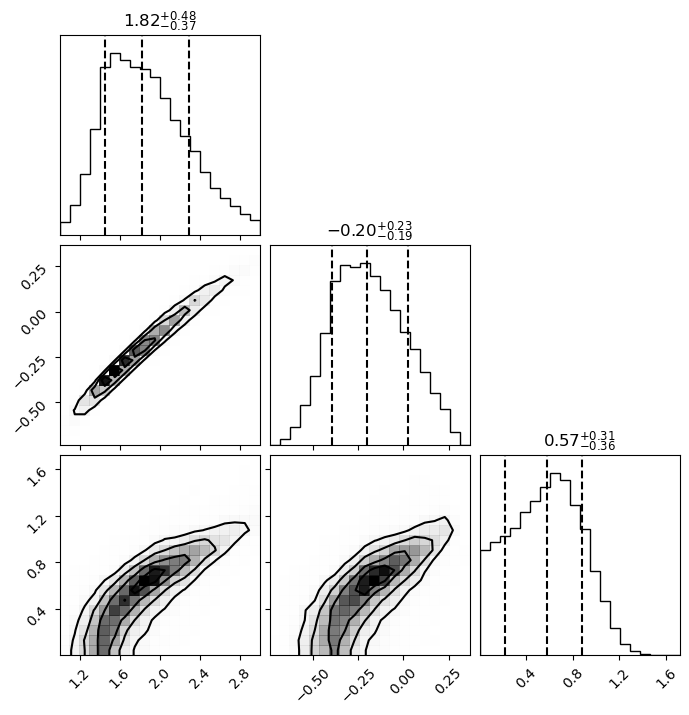

In [5]:
fig = corner.corner(stack, show_titles=True, quantiles=[0.16, 0.5, 0.84], plot_datapoints=False)

### now the SHMR plot using the 500 walkers in the final time step

In [6]:
halo_masses = np.log10(np.logspace(6, 13, 100)) # just for the model

SHMR_mat = np.zeros(shape=(last_sample.shape[0], halo_masses.shape[0]))
for i,val in enumerate(last_sample):
    alpha_i, delta_i, sigma_i = val
    lgMs = galhalo.SHMR_2D(halo_masses, alpha_i, delta_i, 0) ### need to set this to zero!
    SHMR_mat[i] = lgMs

In [7]:
lgMh_dat = np.load("../../data/MCMC/SAGA_0_lgMh.npy")
lgMs_dat = np.load("../../data/MCMC/SAGA_0_lgMs.npy")

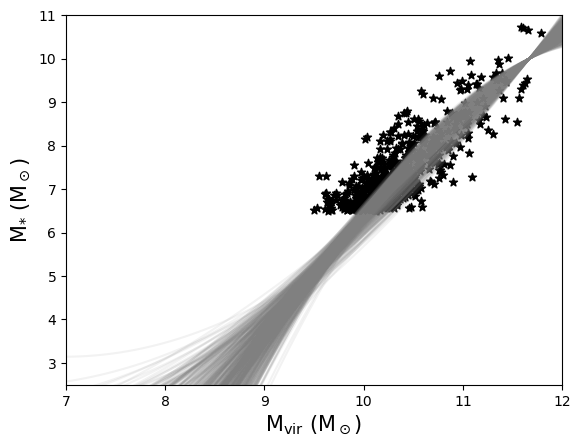

In [8]:
for i in SHMR_mat:
    plt.plot(halo_masses, i, alpha=0.1, color="grey")

plt.scatter(lgMh_dat.flatten(), lgMs_dat.flatten(), color="black", marker="*")

plt.ylim(2.5,11)
plt.xlim(7,12)
plt.ylabel("M$_{*}$ (M$_\odot$)", fontsize=15)
plt.xlabel("M$_{\mathrm{vir}}$ (M$_\odot$)", fontsize=15)
plt.show()

### now to make the stats figures

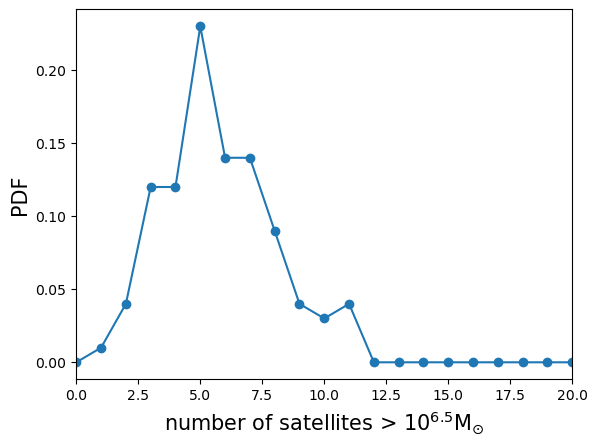

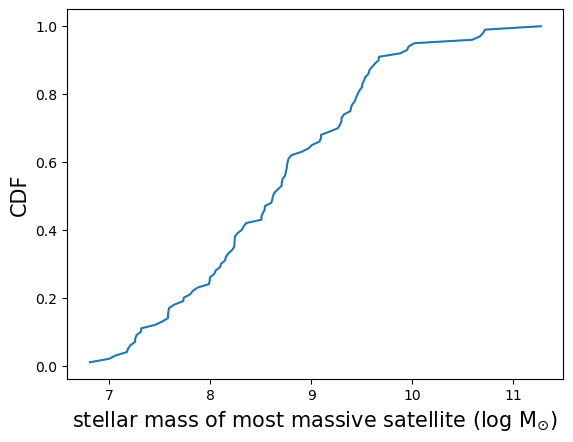

In [9]:
data = mcmc_aux.SAGA0_survey([1.9,-0.2,0.6])
data.get_stats(min_mass=6.5)

In [10]:
def forward(theta):
    models = mcmc_aux.satgen_models(theta, data.lgMh, Nsamples=3)
    models.get_stats(min_mass=6.5)
    return models.stat.Pnsat, models.stat.Msmax, models.stat.ecdf_MsMax

In [11]:
w, e, x = forward(last_sample[0])

In [12]:
Pnsat_mat = np.zeros(shape=(last_sample.shape[0], w.shape[0]))
Msmax_mat = np.zeros(shape=(last_sample.shape[0], e.shape[0]))
Msmaxe_mat = np.zeros(shape=(last_sample.shape[0], e.shape[0]))


for i, theta in enumerate(last_sample):
    tPnsat, tMsmax, tecdf_MsMax = forward(theta)
    Pnsat_mat[i] = tPnsat
    Msmax_mat[i] = tMsmax      
    Msmaxe_mat[i] = tecdf_MsMax      

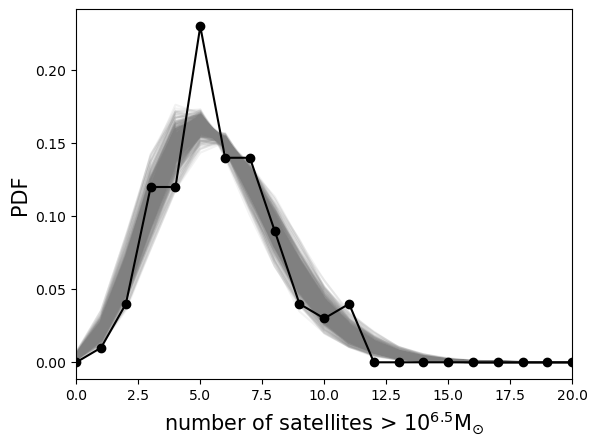

In [13]:
for i in Pnsat_mat:
    plt.plot(np.arange(i.shape[0]),i, color="grey", alpha=0.1)
plt.plot(np.arange(data.stat.Pnsat.shape[0]),data.stat.Pnsat,marker="o", color="black")
plt.xlabel("number of satellites > $10^{"+str(6.5)+"} \mathrm{M_{\odot}}$", fontsize=15)
plt.ylabel("PDF", fontsize=15)
plt.xlim(0,20)
plt.show()

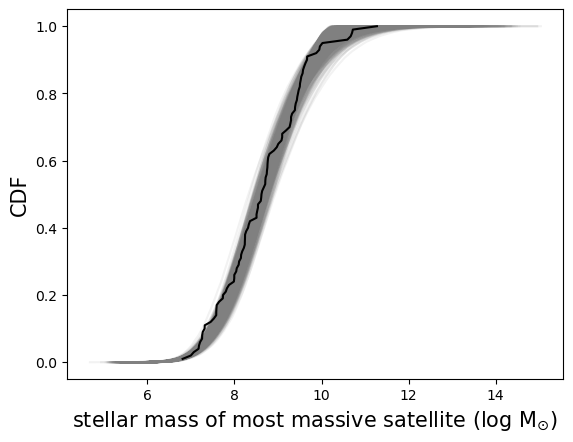

In [14]:
for i, val in enumerate(Msmax_mat):
    plt.plot(val, Msmaxe_mat[i], color="grey", alpha=0.1)
plt.plot(data.stat.Msmax, data.stat.ecdf_MsMax, color="black")
plt.xlabel("stellar mass of most massive satellite ($\mathrm{log\ M_{\odot}}$)", fontsize=15)
plt.ylabel("CDF", fontsize=15)
plt.show()        